In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, euclidean_distances
from scipy.stats import entropy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from sklearn.utils import shuffle

In [62]:
with open("ionosphere.data") as data:
    data = np.genfromtxt(data,delimiter = ",",dtype=str)
    y = (data[:,-1]=='g')*2-1 
    X = data[:,:-1].astype(float)

## Baseline model

In [58]:
# Repeat the experiment 10 times for baseline
n_repetitions = 10
baseline_losses = []
baseline_times = []

for i in range(n_repetitions):
    # Split dataset
    X, y = shuffle(X, y, random_state=i)
    X_train = X[:200]  # First 200 data points
    y_train = y[:200]
    X_test = X[200:350]  # Next 150 data points
    y_test = y[200:350]


    # Calculate distances for gamma_J and create geometrically spaced grid
    distances = euclidean_distances(X_train, X_train)
    np.fill_diagonal(distances, np.inf)
    min_dist = np.min(distances, axis=1)
    gamma_J = 1 / (2 * np.median(min_dist)**2)
    gamma_values = gamma_J * np.logspace(-4, 4, num=9)

    # Set up parameter grid for C and gamma
    param_grid = {'C': np.logspace(-3, 3, 7), 'gamma': gamma_values}

    # Grid search with 5-fold cross-validation
    start_time = time.time()
    clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    baseline_times.append(time.time() - start_time)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    baseline_loss = np.sum(y_pred != y_test) / len(y_test)
    baseline_losses.append(baseline_loss)

# Calculate average loss and time
average_loss = np.mean(baseline_losses)
average_time = np.mean(baseline_times)

print("Average loss: ", average_loss)
print("Average time: ", average_time)

Average loss:  0.06733333333333333
Average time:  2.779201555252075


## PAC-Bayesian

In [64]:
def KL(p, q):
    return entropy(p, q)

def bound(lambd, loss, rho, m, n, r, delta):
    a = np.sum(rho * loss.T) / (1 - lambd / 2)
    b = (KL(rho, 1 / m * np.ones(len(rho))) + np.log(2 * np.sqrt(n - r) / delta))
    c = lambd * (1 - lambd / 2) * (n - r)
    return a + b / c

def simulate(ms, rs, average_loss, X_train, y_train, X_test, y_test, gamma_J, n):
    idx = np.arange(len(X_train))
    Losses, times, bounds = [], [], []

    for m_value in ms:
        m_int = int(m_value)
        start_time = time.time()
        L, models = [], []

        for _ in range(m_int):
            while True:
                s = np.random.choice(idx, r, replace=False)
                if len(np.unique(y_train[s])) > 1:
                    break
            clf = SVC(kernel='rbf', gamma=gamma_J)
            clf.fit(X_train[s], y_train[s])
            models.append(clf)
            test = np.random.choice(list(set(idx).difference(s)), n - r)
            pred = clf.predict(X_train[test])
            L.append(np.sum(pred != y_train[test]) / len(pred))

        L = np.array(L)
        lambdas = np.ones(len(L)) / len(L)
        rhos = np.ones(len(L)) / len(L)
        delta = 0.05

        for _ in range(40):
            a1 = 2 * (n - r) * np.sum(rhos * L.T)
            b1 = KL(rhos, 1 / m_int * np.ones(len(rhos)))
            c1 = np.log(2 * np.sqrt(n - r) / delta)
            lambdas = 2 / (np.sqrt(a1 / (b1 + c1) + 1) + 1)

        L_val_min = np.min(L)
        _sum = np.sum(1 / m_int * np.exp(-lambdas * (n - r) * (L - L_val_min)))
        rhos = (1 / m_int * np.exp(-lambdas * (n - r) * (L - L_val_min))) / (_sum)
        rhos = np.array(rhos, dtype=np.float64)

        guesses = np.array([model.predict(X_test) for model in models])
        guesses = guesses.astype(np.float64)
        guess = np.sign(np.sum(rhos * guesses.T, axis=1))
        vote_acc = np.mean(guess == y_test)
        times.append(time.time() - start_time)
        pac_loss = 1 - vote_acc
        loss_diff = pac_loss - average_loss
        Losses.append(loss_diff)

        B = bound(lambdas, loss_diff, rhos, m_int, n, r, delta)
        bounds.append(B)

    return Losses, times, bounds

# Define m and r values
d = X_train.shape[1]  # Input dimension
n = len(X_train)  # Number of training samples
m_values = np.unique(np.logspace(0.3, 2.54, 20).astype(int))
r_values = np.linspace(2, d + 1, 20).astype(int)

# Define ms values and simulate
ms = np.unique(np.logspace(0.3, 2.54, 20).astype(int))
all_res, times2, bounds = [], [], []

for m in m_values:
    for r in r_values:
        r = min(r, len(X_train))
        losses, times, bnds = simulate([m], [r], average_loss, X_train, y_train, X_test, y_test, gamma_J, n)
        all_res.append(losses)
        times2.append(times)
        bounds.append(bnds)

all_res = np.array(all_res)
times2 = np.array(times2)
bounds = np.array(bounds)

# Reshape the results for plotting
loss_matrix = np.array(all_res).reshape(len(m_values), len(r_values))
time_matrix = np.array(times2).reshape(len(m_values), len(r_values))
bound_matrix = np.array(bounds).reshape(len(m_values), len(r_values))

## Plotting

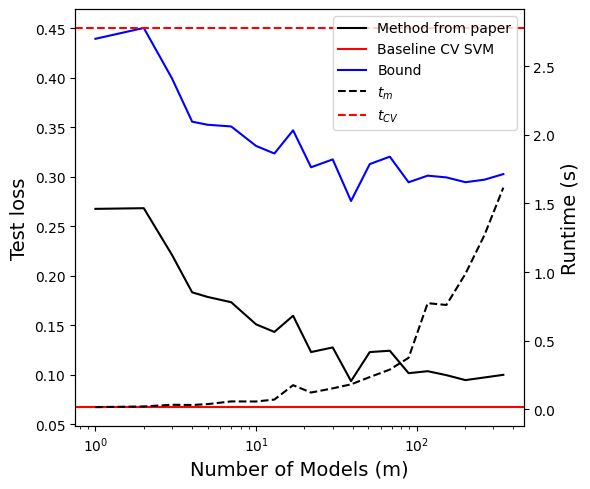

In [65]:
fig, ax1 = plt.subplots(figsize=(6, 5))

# Calculate the average loss for each m value
plot_loss = np.mean(loss_matrix, axis=1)

# Plot the average loss from our method
ax1.plot(m_values, plot_loss, color="black", label="Method from paper")
ax1.set_xscale("log")
ax1.set_ylabel("Loss", color="black")

# Baseline loss for comparison
plot_base = average_loss

# Plot the baseline loss as a horizontal line
ax1.axhline(y=plot_base, color="red", linestyle='-', label="Baseline CV SVM")
ax1.set_xscale("log")
ax1.set_ylabel("Loss", color="black")

# Calculate the average bound for each m value
plot_bound = np.mean(bound_matrix, axis=1)

# Plot the average bound
ax1.plot(m_values, plot_bound, color="blue", label="Bound")
ax1.set_xscale("log")
ax1.set_ylabel("Test loss", color="black", fontsize=14)

# Create a second y-axis for the runtime
ax2 = ax1.twinx()

# Calculate the average runtime for each m value
plot_times = np.mean(time_matrix, axis=1)

# Plot the average runtime
ax2.plot(m_values, plot_times, '--', color="black", label="$t_m$")
ax2.set_ylabel("Runtime (s)", fontsize=14)

# Baseline runtime for comparison
base_time = average_time

# Plot the baseline runtime as a horizontal line
ax2.axhline(y=base_time, color="red", linestyle='--', label="$t_{CV}$")
ax2.set_ylabel("Runtime (s)")

ax1.set_xlabel("Number of Models (m)", fontsize=14)

# Add legend
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()